In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import leastsq
import math
from scipy.optimize import minimize

In [2]:
def flux_data_err(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/Flux Maps/%s/subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_9_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2,emp_wing) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0],central_tab.field('emp_fact_wing')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    print (emp_Hb_blr)
    (blr_err_final,wing_err_final,core_err_final) = (emp_Hb_blr*Hb_blr_err,emp_wing*OIII_br_err,OIII_nr_err)
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,blr_err_final,wing_err_final,core_err_final
    

In [3]:
def theta_filter(theta_out):
    remainder = theta_out % 360
    #print (remainder)
    if remainder > 90 and remainder < 180:
        theta = 90 - remainder
    elif remainder > 180 and remainder <270:
         theta = 270 - remainder
    elif remainder > 270 and remainder < 360:
         theta = remainder - 360
    elif remainder > 360:
        remainder = remainder - 360
    else:
         theta = remainder
    return theta

In [4]:
def ellip_moffat2D(p,xy):
    xy=(x,y)
    [amp, x0, y0, a, b, theta, alpha] = p 
    theta = theta_filter(theta)
    
    A = 4*((2**(1/alpha))-1)*(((np.cos(theta*(np.pi/180)))/a)**2 + ((np.sin(theta*(np.pi/180)))/b)**2) 
    B = 4*((2**(1/alpha))-1)*(((np.sin(theta*(np.pi/180)))/a)**2 + ((np.cos(theta*(np.pi/180)))/b)**2) 
    C = 4*((2**(1/alpha))-1)*2.0*(np.sin(theta*(np.pi/180)))*(np.cos(theta*(np.pi/180)))*((1/a)**2-(1/b)**2)
    g = amp*((1.0+A*(x-x0)**2+B*(y-y0)**2+C*(x-x0)*(y-y0))**(-alpha))
    #h = (data - g)/error
    return g

def ellip_moffat2D_fixkin(p,xy,data,error,fixed_param):
    [a,b,theta,alpha] = fixed_param
    theta = theta_filter(theta)
    xy=(x,y)
    [amp, x0, y0] = p    
    A = 4*((2**(1/alpha))-1)*(((np.cos(theta*(np.pi/180)))/a)**2 + ((np.sin(theta*(np.pi/180)))/b)**2) 
    B = 4*((2**(1/alpha))-1)*(((np.sin(theta*(np.pi/180)))/a)**2 + ((np.cos(theta*(np.pi/180)))/b)**2) 
    C = 4*((2**(1/alpha))-1)*2.0*(np.sin(theta*(np.pi/180)))*(np.cos(theta*(np.pi/180)))*((1/a)**2-(1/b)**2)
    g = amp*((1.0+(A*((x-x0)**2))+(B*((y-y0)**2))+(C*(x-x0)*(y-y0)))**(-alpha))
    h = (data - g)/error
    return h.ravel()

In [30]:
def chisqfunc(amp, x0, y0, a, b, theta, alpha):
    [amp, x0, y0, a, b, theta, alpha] = p
    model = ellip_moffat2D(p,xy)
    chisq = numpy.sum(((Hb_blr_br_data.ravel() - model.ravel())/Hb_blr_br_err.ravel())**2)
    return chisq


In [31]:
def elliptical_moffat_alt(data,err,box_size,amp,x0,y0,muse_sampling_size,fix_par,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    x0 = [amp,x0,y0,3,3,np.random.randint(-5,5),3]
    #data = data.ravel()
    #model = model.ravel()
    #err = err.ravel()
    result =  minimize(chisqfunc,x0)
    return result

In [32]:
def elliptical_moffat_fit(data,error,box_size,amp,x0,y0,muse_sampling_size,fix_par,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    
    if muse_sampling_size == 0.4:
        (a,b) = (3,3)
    else:
        (a,b) = (4,4)

    if fix_par is None:
        p= [amp,x0,y0,a,b,np.random.randint(-5,5),3]
        popt,pcov = leastsq(ellip_moffat2D,x0=p,args=(xy,data,error),maxfev = 10000000)
        [amp_out,x0_out,y0_out,a_out,b_out,theta_out,alpha_out]= popt
        theta_true = theta_filter(theta_out)        
       
        #[fwhm1_out,fwhm2_out] = [2*a_out*np.sqrt(2**(1/alpha_out)-1),2*b_out*np.sqrt(2**(1/alpha_out)-1)]
        #par_fit = [amp_out,x0_out,y0_out,a_out,b_out,theta_out,alpha_out]
        par = [amp_out,x0_out,y0_out,a_out,b_out,theta_true,alpha_out]
        mod_rav = data.ravel() - ellip_moffat2D(popt,xy,data,error)*error.ravel()
       # model = ellip_moffat2D_model(xy,par)
    else:
        p= [amp,x0,y0]
        popt,pcov = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,data,error,fix_par),maxfev = 10000000)
        [amp_out,x0_out,y0_out]= popt
        par = popt
        mod_rav = data.ravel() - ellip_moffat2D_fixkin(popt,xy,data,error,fix_par)*error.ravel()
        #model =  ellip_moffat2D_fixkin_model(xy,par,fix_par)
    model = mod_rav.reshape(box_size,box_size)
    #model = ellip_moffat2D_model(xy,par)
    residual = data-model
    res = (residual/error)

    parameters_MC = np.zeros((len(par),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if fix_par is None:
            p= [amp,x0,y0,a,b,np.random.randint(-5,5),3]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D,x0=p,args=(xy,iteration_data,error),maxfev = 10000000)
            [amp_MC,x0_MC,y0_MC,a_MC,b_MC,theta_MC,alpha_MC]= popt_MC
            theta_MC = theta_filter(theta_MC)        
            #[fwhm1_MC,fwhm2_MC] = [2*a_MC*np.sqrt(2**(1/alpha_MC)-1),2*b_MC*np.sqrt(2**(1/alpha_MC)-1)]
            par_MC = [amp_MC,x0_MC,y0_MC,a_MC,b_MC,theta_MC,alpha_MC]   
            parameters_MC[:,l] = par_MC    
        else:
            p= [amp,x0,y0]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,iteration_data,error,fix_par),maxfev = 10000000)
            [amp_MC,x0_out,y0_out]= popt_MC
            parameters_MC[:,l] = popt_MC    
    parameters_err = np.std(parameters_MC,1) 
    return par,parameters_err,model,res

In [33]:
def chi_squared(data,model,err):
    res = data - model
    a = np.sum((res/err)**2)
    return a

def red_chi_squared(data,model,err,n_free):
    dof = len(data.flatten()) - n_free
    res = data - model
    k = res/err
    k[k>10**10]=0
    l = k[k!=0]
    a = np.sum(l**2)
    red = a/dof
    return red


In [34]:
def moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'a':3,'b':4,'theta':5,'alpha':6,'fwhm1':7,'fwhm2':8,'amp_OIII_br':9,'x0_OIII_br':10,'y0_OIII_br':11,'amp_OIII_nr':12,'x0_OIII_nr':13,'y0_OIII_nr':14}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[full_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[full_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/3_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)

def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_res,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_res,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_res,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/3_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')

def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_3_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [35]:
def algorithm_script(obj,z,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):  
    print ('%s'%(obj))
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[0]
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    print (brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y)
    
    if box_size ==17:
        muse_sampling_size = 0.2
    else:
        muse_sampling_size = 0.4
    
    Hb_par = elliptical_moffat_alt(Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,muse_sampling_size,None,100)
  
    #(Hb_par,Hb_error,Hb_model,Hb_res) = elliptical_moffat_fit(Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,muse_sampling_size,None,1000)
    print (Hb_par,Hb_error)
    #red_chi_sq_Hb = red_chi_squared(Hb_blr_br_data,Hb_model,Hb_blr_br_err,5)   
    #print (red_chi_sq_Hb)
    #fixed_param = [Hb_par[3],Hb_par[4],Hb_par[5],Hb_par[6]]
    #(OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = elliptical_moffat_fit(OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,muse_sampling_size,fixed_param,1000)   
    #print (OIII_br_par,OIII_br_error)
    #(OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = elliptical_moffat_fit(OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,muse_sampling_size,fixed_param,1000)   
    print (OIII_nr_par,OIII_nr_error)

    #(full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    #moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE")
    #maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    #fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err)
    
    plt.imshow(Hb_blr_br_data,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(Hb_model,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(OIII_br_data,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_br_model,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_nr_data,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    plt.imshow(OIII_nr_model,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    

In [36]:
z = {"HE0021-1810":0.05352}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

1.356066
HE0021-1810
1.356066
4 4


TypeError: chisqfunc() missing 6 required positional arguments: 'x0', 'y0', 'a', 'b', 'theta', and 'alpha'

1.5679197
HE0021-1819
1.5679197
7 8
[0.05797303271584831, 7.6363452712994535, 8.123442056681528, 4.102113422629255, 3.787780451044343, 32.043672663089396, 2.7423949820230233] [9.72302697e-04 1.70000983e-02 1.60370701e-02 1.16126961e-01
 1.15266387e-01 2.99289325e+01 1.06666126e-01]
[0.35819099 7.38065173 8.28363519] [0.00104139 0.00662895 0.00724401]
[1.93715763 7.47334439 8.00781286] [0.00235059 0.00260425 0.00301051]


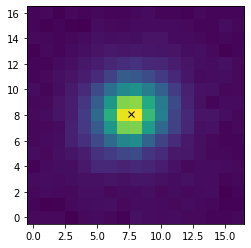

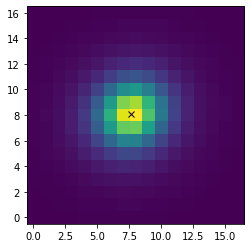

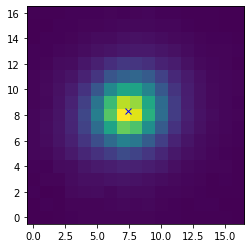

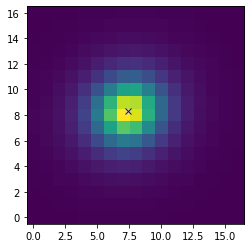

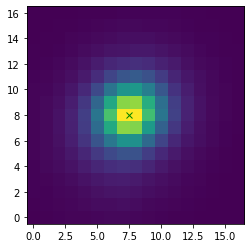

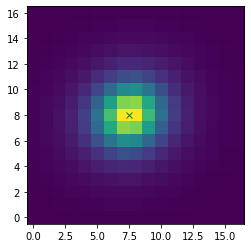

1.6406764
HE0040-1105
1.6406764
7 8
[0.3737478114733641, 7.646229946905326, 7.8129288712936775, 3.5292648936612765, 3.751776615543687, 89.43284997087903, 2.672428483111588] [2.10189464e-03 5.56787328e-03 5.67454489e-03 7.88356055e-02
 7.80271464e-02 3.35017046e+01 3.24358893e-02]
[0.63675246 8.1770042  7.67995384] [0.00284518 0.01086495 0.00924032]
[3.9409088  7.45491629 8.00512206] [0.00460127 0.00373374 0.00291601]


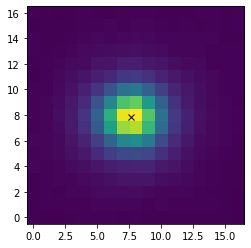

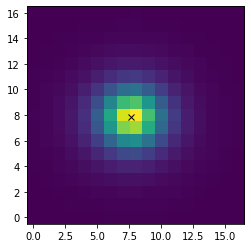

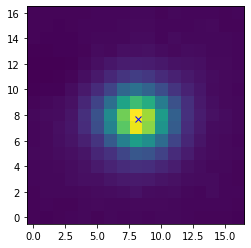

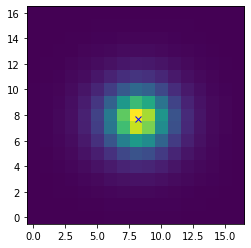

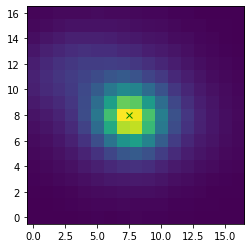

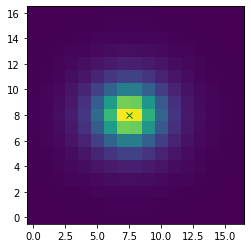

2.0286798
HE0108-4743
2.0286798
3 4


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


[1.251461616509642, 4.056600414544454, 4.0451337137262975, 3.8032546746155305, 3.62785922829224, -32.95106740202755, 2.4297001697200553] [4.15565433e-02 3.19111056e-02 3.30694384e-02 1.52847922e-01
 1.43788499e-01 4.45016021e+01 2.85789825e-01]
[2.27472109 3.76312557 4.13852261] [0.03339026 0.03588753 0.05041482]
[6.74992306 3.18365513 4.1368279 ] [0.02368563 0.00986091 0.00885148]


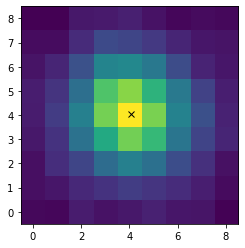

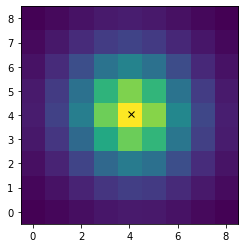

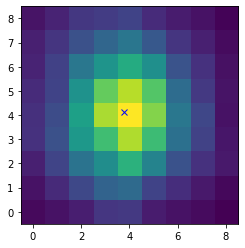

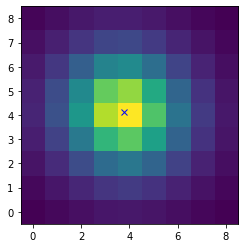

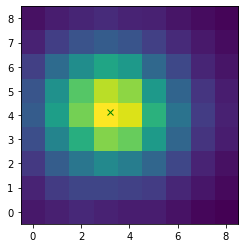

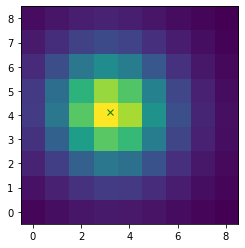

1.6333879
HE0114-0015
1.6333879
8 8
[0.12564452531346265, 7.645920108424598, 7.390200747282883, 3.0936222034430787, 2.851527361731556, -8.331225402002929e-06, 2.9002445859353836] [3.74496711e-03 2.50974039e-02 2.64900850e-02 1.43543020e-01
 1.41635962e-01 3.40191750e+01 2.59533901e-01]
[0.08019332 7.80523323 8.16642187] [0.00367516 0.07383771 0.10726269]
[0.64028963 7.70481351 7.56982689] [0.00394231 0.01078535 0.01215167]


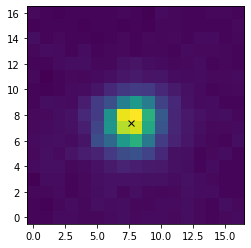

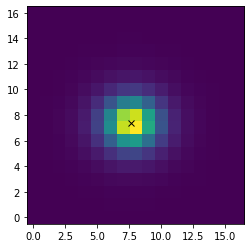

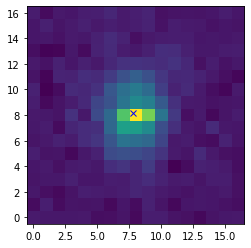

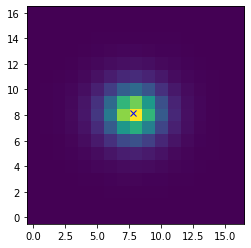

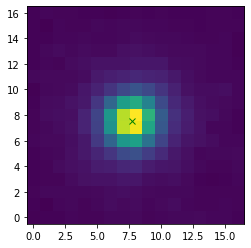

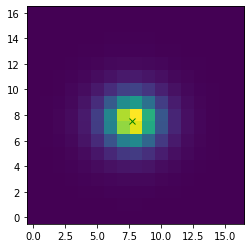

1.416731
HE0119-0118
1.416731
4 4
[1.683614640673691, 4.1117077390255865, 4.057888501441247, 2.0010957122552946, 2.076287447965415, 87.27735974523239, 2.4747970202222875] [5.22080114e-02 1.46826098e-02 1.42137670e-02 5.69634369e-02
 5.40805289e-02 5.33511362e+01 1.01681747e-01]
[9.28792097 4.0291007  3.97910208] [0.03028388 0.0036188  0.00399054]
[13.82300009  4.09706958  3.97930289] [0.03656528 0.00273052 0.00307991]


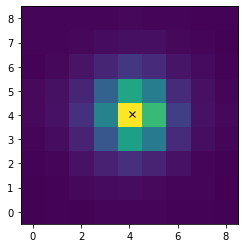

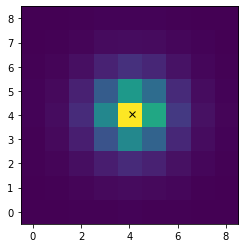

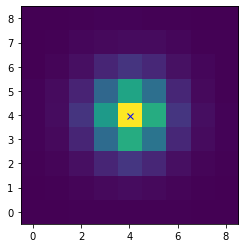

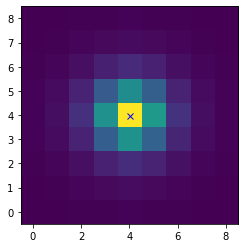

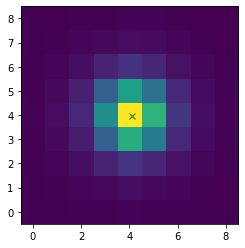

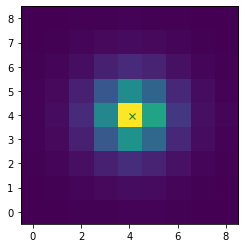

1.4458556
HE0212-0059
1.4458556
8 8
[0.28673187386152854, 8.271512811621088, 7.633288915023467, 3.600759786181202, 3.5499033512046205, 84.70843639178202, 1.800717247201458] [7.04894816e-03 1.74065866e-02 1.72531540e-02 5.84302669e-02
 5.95772871e-02 3.82161638e+01 3.04244219e-02]
[0.24315664 8.45847137 8.96444605] [0.00369475 0.02177096 0.05181781]
[2.318316   8.31962383 7.59869514] [0.00379752 0.00394915 0.00451538]


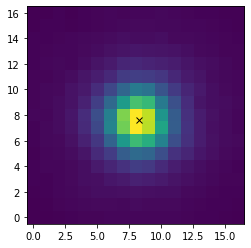

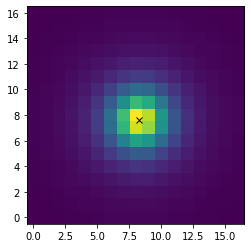

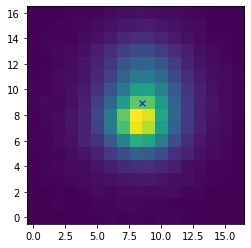

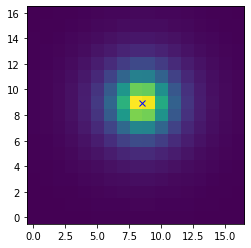

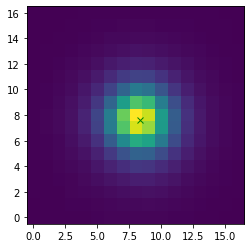

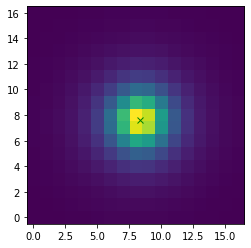

1.7209688
HE0224-2834
1.7209688
4 4


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':


[0.3514040702411261, 3.8842334032158066, 4.003868613651273, 4.171378581037808, 4.308852340561257, -31.35555143468082, 3.153472536417302] [2.50647049e-03 7.11749575e-03 7.67210758e-03 7.54457382e-02
 7.23615857e-02 4.36993805e+01 1.20154404e-01]
[0.98317336 3.93285265 3.93119019] [0.00533328 0.013104   0.0133521 ]
[2.95961253 3.37039959 4.26629978] [0.00487006 0.00506177 0.00490737]


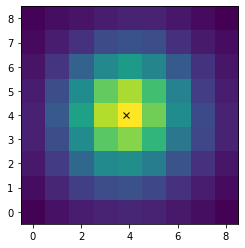

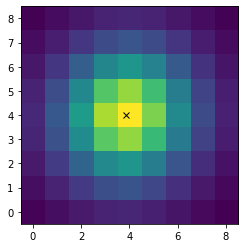

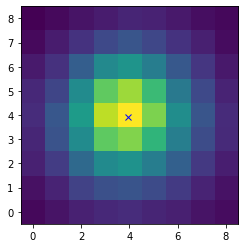

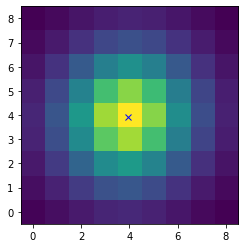

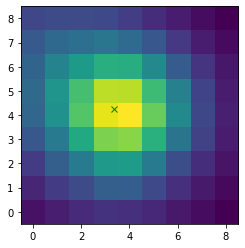

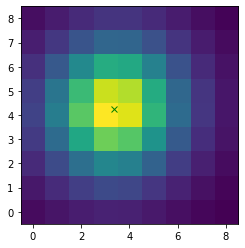

2.192149
HE0227-0913
2.192149
4 4
[7.20460716785033, 4.003452821271084, 4.079645274143045, 3.188627240016551, 3.2384512927057103, -9.186445140803698, 2.6109329745761842] [6.67897761e-02 6.52201362e-03 6.35688826e-03 3.29446441e-02
 3.25429932e-02 4.53890144e+01 5.35286721e-02]
[0.62521196 4.08990369 4.1683315 ] [0.00661296 0.01893163 0.01933728]
[6.15619169 4.01811518 4.17152617] [0.00757773 0.00231496 0.00238058]


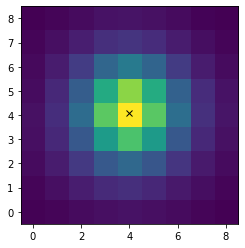

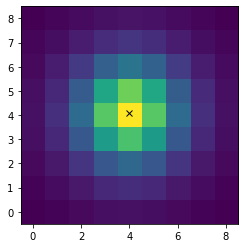

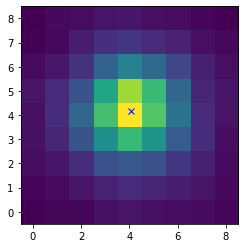

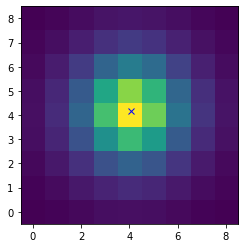

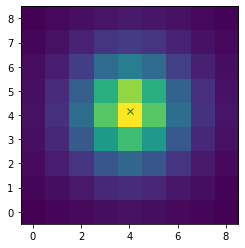

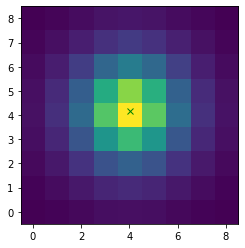

1.8799717
HE0232-0900
1.8799717
4 4
[7.78032733580182, 4.1082918930729, 4.111658123609415, 3.0765904164733318, 3.0485890867976417, -77.7820788557874, 2.576465636944664] [7.69587578e-02 4.03231378e-03 4.37587348e-03 2.09286467e-02
 2.28602903e-02 4.48586010e+01 3.26783345e-02]
[20.55805769  3.74395605  3.9699609 ] [0.23532231 0.01865187 0.0200777 ]
[49.94470101  4.05041248  3.34547743] [0.08069629 0.00190752 0.003527  ]


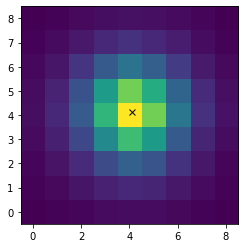

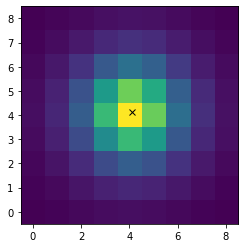

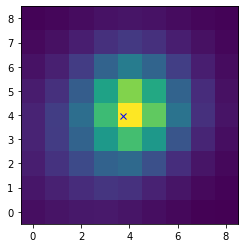

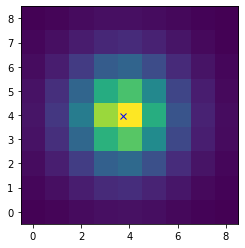

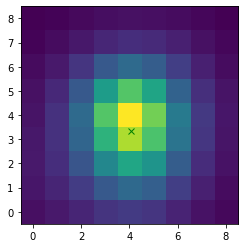

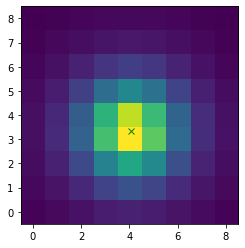

1.6392349
HE0253-1641
1.6392349
4 4
[2.746567993385264, 4.074648857582503, 3.7742013464117794, 2.487168458959309, 2.6309250516866305, 16.455761478288633, 2.9621854479166543] [5.51181147e-02 1.01457469e-02 1.14598450e-02 7.37719615e-02
 7.38901561e-02 4.19564152e+01 1.20259668e-01]
[6.93289949 4.01385898 3.80010015] [0.0147154  0.00289202 0.00312838]
[21.99044544  3.9493375   3.54178554] [0.02635149 0.00170254 0.00182943]


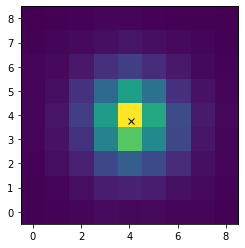

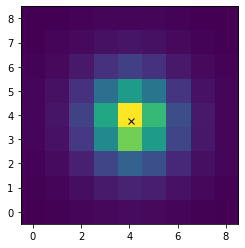

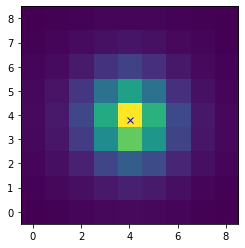

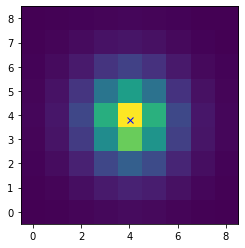

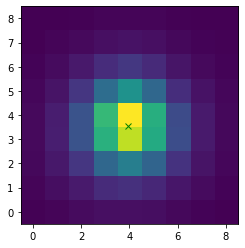

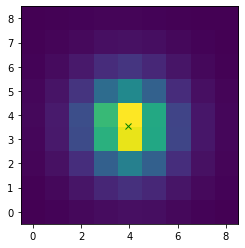

1.6350082
HE0345+0056
1.6350082
4 4


KeyboardInterrupt: 

In [10]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])